# 🧠 Diabetes Prediction using Machine Learning
This notebook demonstrates a complete classification pipeline to predict whether a person is diabetic based on medical features.

**Goals:**
- Perform preprocessing on health-related data
- Build machine learning models (e.g., Logistic Regression, Random Forest)
- Evaluate models with appropriate metrics
- Visualize performance using ROC-AUC curves and classification reports

📦 Dataset: [Pima Indians Diabetes Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

## 📊 1. Data Preprocessing
This section handles data loading, scaling, and train-test splitting.

We also explore null values, class distribution, and encoding if needed.

In [2]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb



path = kagglehub.dataset_download("akshaydattatraykhare/diabetes-dataset")

data = pd.read_csv(path + "/diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


c:\Users\kaiva\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


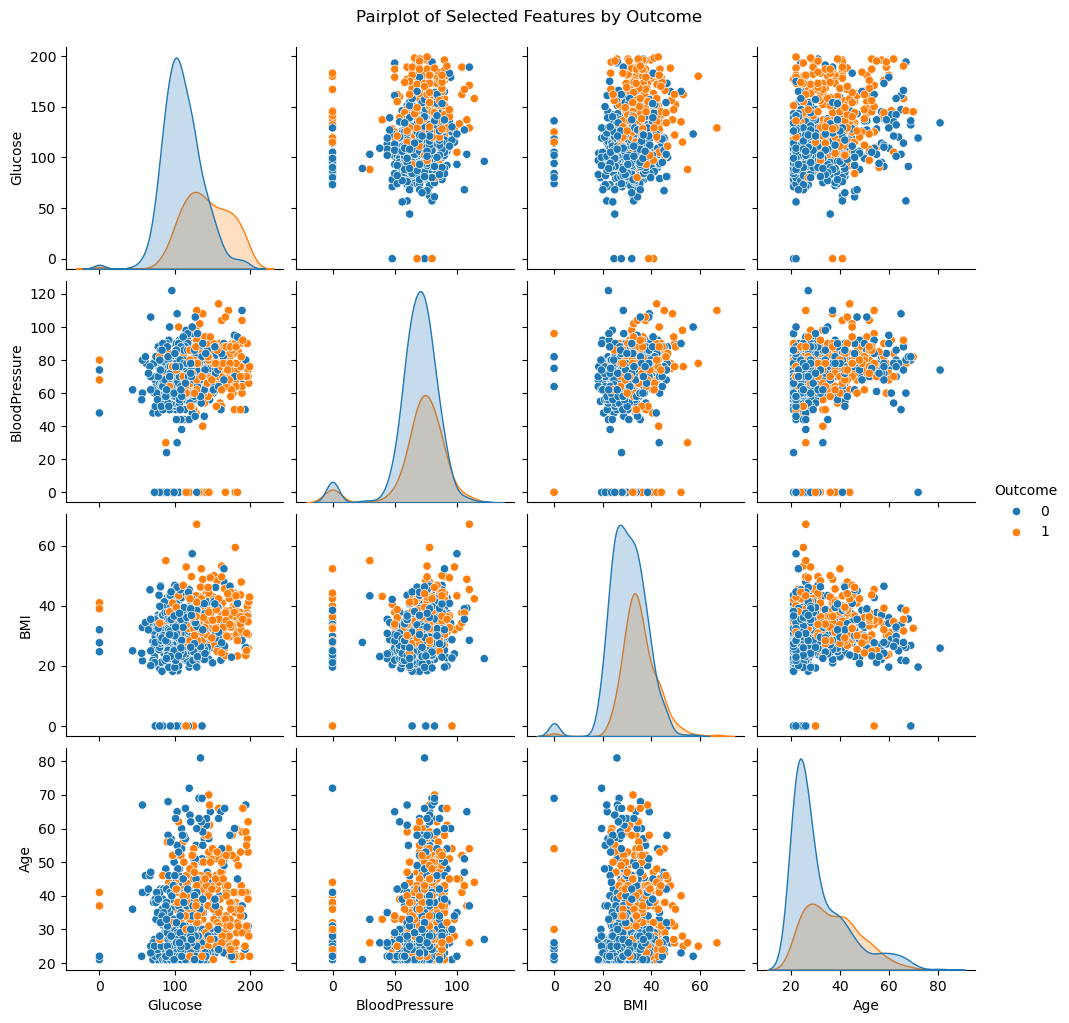

In [4]:
features = ['Glucose', 'BloodPressure', 'BMI', 'Age']
sb.pairplot(data, vars=features, hue='Outcome', diag_kind='kde')
plt.suptitle("Pairplot of Selected Features by Outcome", y=1.02)
plt.show()

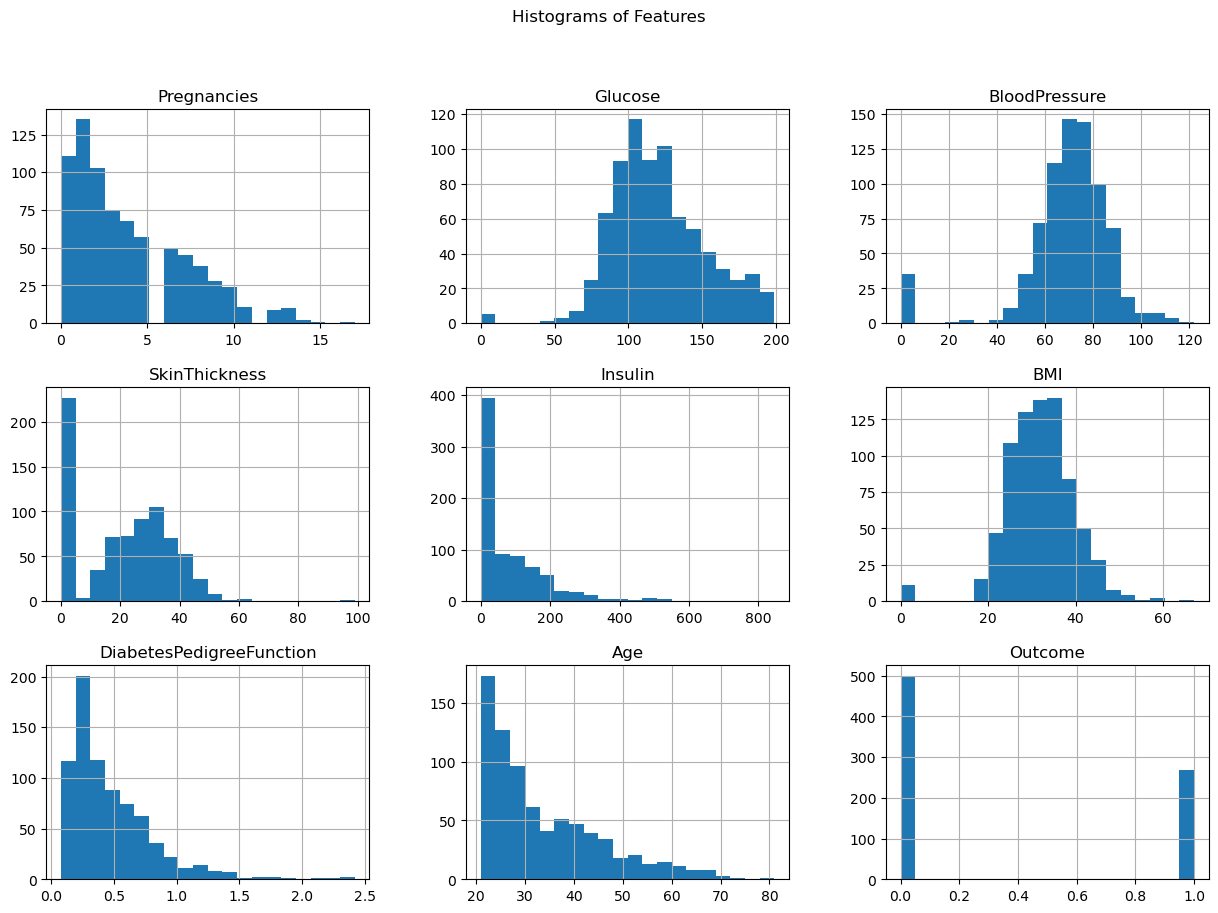

In [5]:
# Histogram for each feature
data.hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Features")
plt.show()

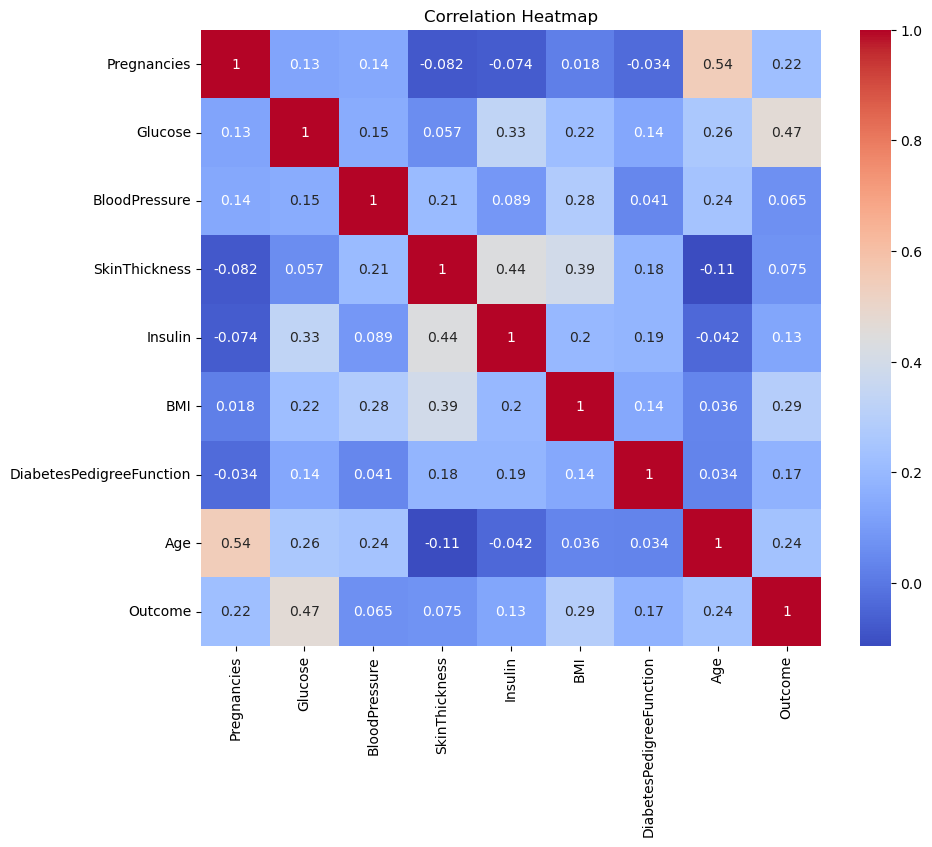

In [6]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

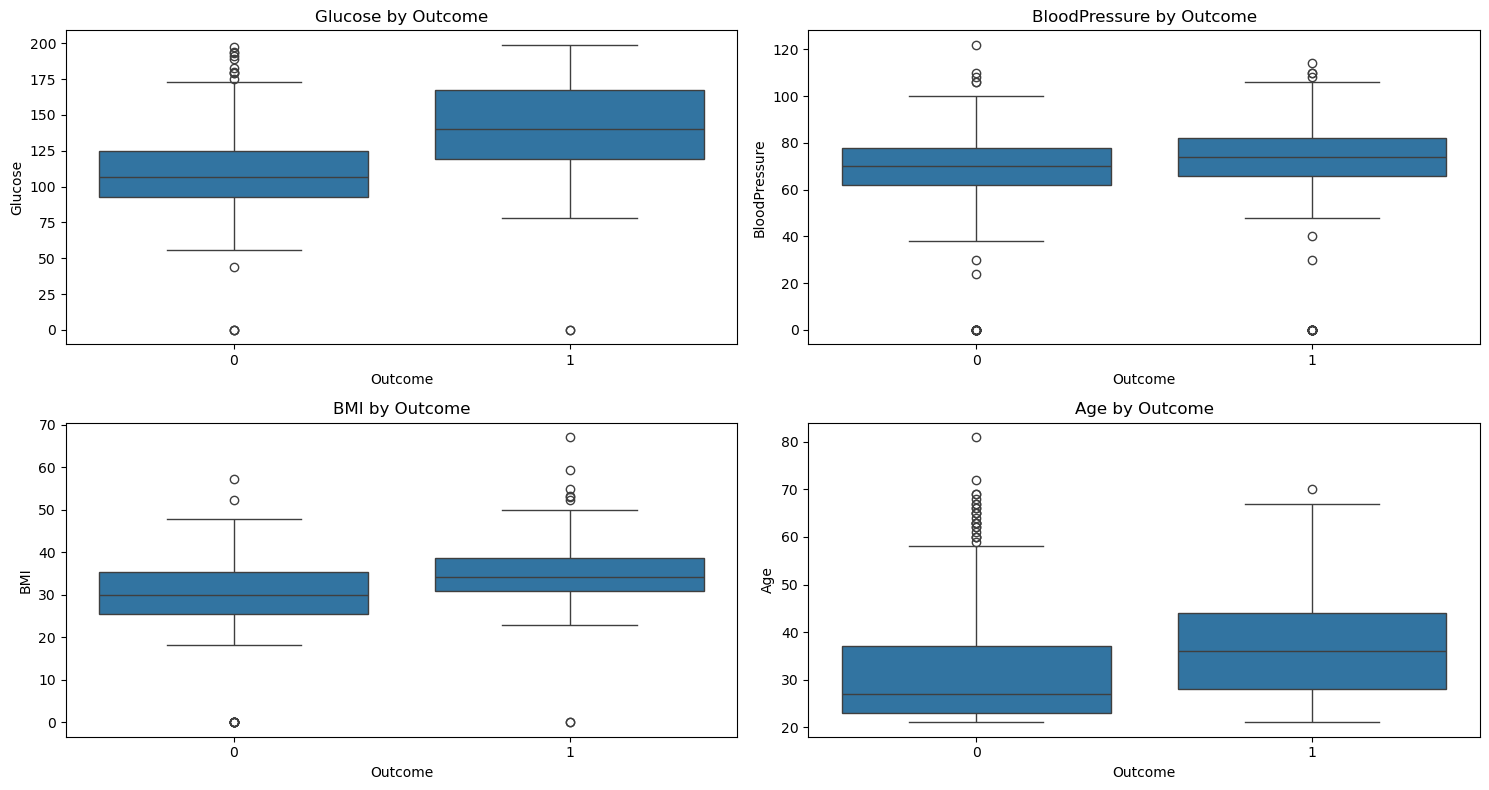

In [7]:
# Boxplots for features grouped by Outcome
features = ['Glucose', 'BloodPressure', 'BMI', 'Age']
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sb.boxplot(x='Outcome', y=feature, data=data)
    plt.title(f"{feature} by Outcome")
plt.tight_layout()
plt.show()

In [17]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer

Importing all the required libraries

In [9]:
X = data.drop('Outcome', axis = 1)
y = data["Outcome"]

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
models = {
    "Logistic Regression (L2)": LogisticRegression(C=1.0, penalty='l2', solver='liblinear'),
    "Logistic Regression (L1)": LogisticRegression(C=1.0, penalty='l1', solver='liblinear'),
    "ElasticNet (LogReg)": LogisticRegression(C=1.0, penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1.0, probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [11]:
model_grid = {
    "Logistic Regression (L2)": {
        "model": LogisticRegression(solver='liblinear'),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ['l2'],
            "max_iter": [100, 500]
        }
    },
    "Logistic Regression (L1)": {
        "model": LogisticRegression(solver='liblinear'),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ['l1'],
            "max_iter": [100, 500]
        }
    },
    "ElasticNet (LogReg)": {
        "model": LogisticRegression(solver='saga'),
        "params": {
            "C": [0.1, 1],
            "penalty": ['elasticnet'],
            "l1_ratio": [0.5],
            "max_iter": [1000]
        }
    },
    "SVM (RBF Kernel)": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "gamma": ['scale', 'auto']
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [3, 5, 7],
            "min_samples_split": [2, 5]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10],
            "min_samples_split": [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5],
            "learning_rate": [0.1, 0.01]
        }
    }
}

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_classifiers_with_roc(models, X_train, X_test, y_train, y_test, scale_models=None):
    """
    Evaluate classification models with accuracy, classification report, and ROC-AUC curves.
    
    Parameters:
    - models: dict of model name → sklearn-compatible model
    - X_train, X_test: features
    - y_train, y_test: targets
    - scale_models: list of model names that require scaling (optional)
    """

    if scale_models is None:
        scale_models = [name for name in models if "Logistic" in name or "SVM" in name or "ElasticNet" in name]

    # Standardize features if needed
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        print(f"\n🔍 Evaluating: {name}")
        
        # Use scaled or unscaled data
        if name in scale_models:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            if hasattr(model, "predict_proba"):
                y_scores = model.predict_proba(X_test_scaled)[:, 1]
            else:
                y_scores = model.decision_function(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if hasattr(model, "predict_proba"):
                y_scores = model.predict_proba(X_test)[:, 1]
            else:
                y_scores = model.decision_function(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Accuracy: {acc:.4f}")
        print("📋 Classification Report:\n", classification_report(y_test, y_pred))

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # Final ROC-AUC plot
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title("🏁 ROC-AUC Curve for All Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




🔍 Evaluating: Logistic Regression (L2)
✅ Accuracy: 0.7532
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


🔍 Evaluating: Logistic Regression (L1)
✅ Accuracy: 0.7468
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        99
           1       0.64      0.67      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154


🔍 Evaluating: ElasticNet (LogReg)
✅ Accuracy: 0.7532
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.

c:\Users\kaiva\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kaiva\AppData\Local\Temp\ipykernel_7124\1848992241.py:60: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  plt.tight_layout()
c:\Users\kaiva\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


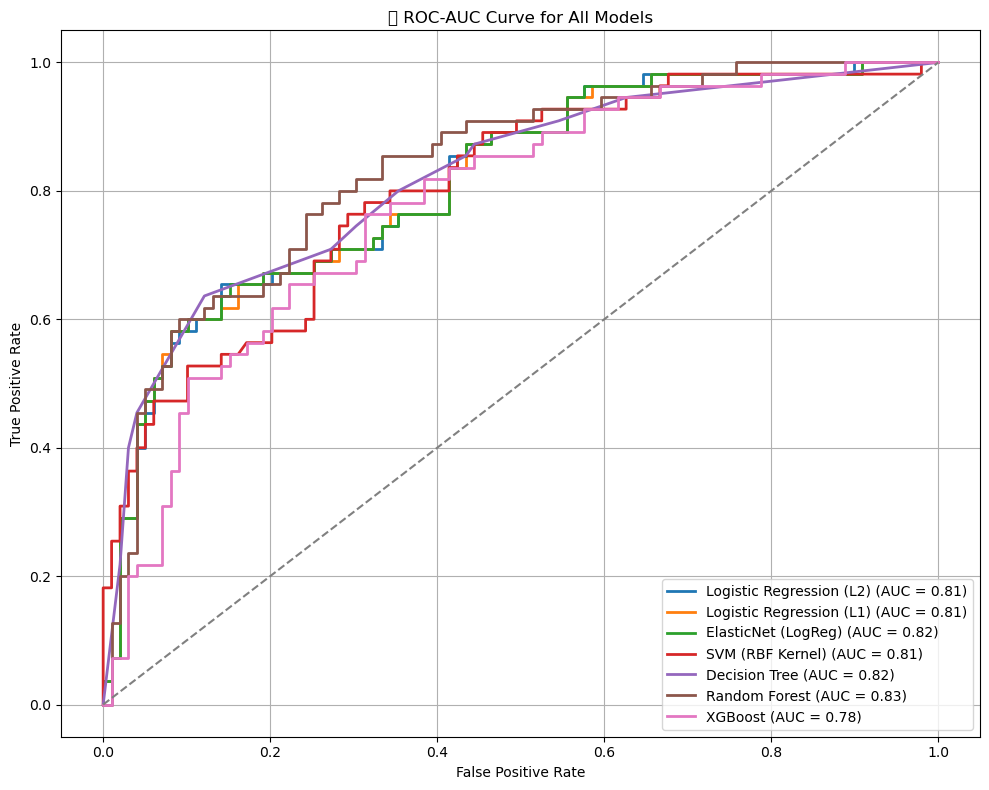

In [13]:
evaluate_classifiers_with_roc(models, X_train, X_test, y_train, y_test)

In [15]:
def evaluate_tuned_classifiers(model_grid, X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    scale_models = ["Logistic Regression", "ElasticNet", "SVM"]

    plt.figure(figsize=(10, 8))

    for name, config in model_grid.items():
        print(f"\n🔍 Tuning and Evaluating: {name}")
        model = config["model"]
        params = config["params"]

        # Scale-sensitive?
        scaled = any(keyword in name for keyword in scale_models)
        X_train_input = X_train_scaled if scaled else X_train
        X_test_input = X_test_scaled if scaled else X_test

        # StratifiedKFold for classification
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Grid search
        grid = GridSearchCV(model, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train_input, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_input)
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Best Params: {grid.best_params_}")
        print(f"✅ Accuracy: {acc:.4f}")
        print("📋 Classification Report:\n", classification_report(y_test, y_pred))

        # ROC-AUC plotting
        if hasattr(best_model, "predict_proba"):
            y_scores = best_model.predict_proba(X_test_input)[:, 1]
        else:
            y_scores = best_model.decision_function(X_test_input)

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # Finalize ROC plot
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title("🏁 ROC-AUC Curve (Fine-Tuned Models)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()



🔍 Tuning and Evaluating: Logistic Regression (L2)
✅ Best Params: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
✅ Accuracy: 0.7532
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


🔍 Tuning and Evaluating: Logistic Regression (L1)
✅ Best Params: {'C': 10, 'max_iter': 100, 'penalty': 'l1'}
✅ Accuracy: 0.7532
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


🔍 Tuning and Evaluating: ElasticNet 

c:\Users\kaiva\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:56:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kaiva\AppData\Local\Temp\ipykernel_7124\705110612.py:51: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  plt.tight_layout()
c:\Users\kaiva\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


✅ Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
✅ Accuracy: 0.7727
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83        99
           1       0.71      0.62      0.66        55

    accuracy                           0.77       154
   macro avg       0.76      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



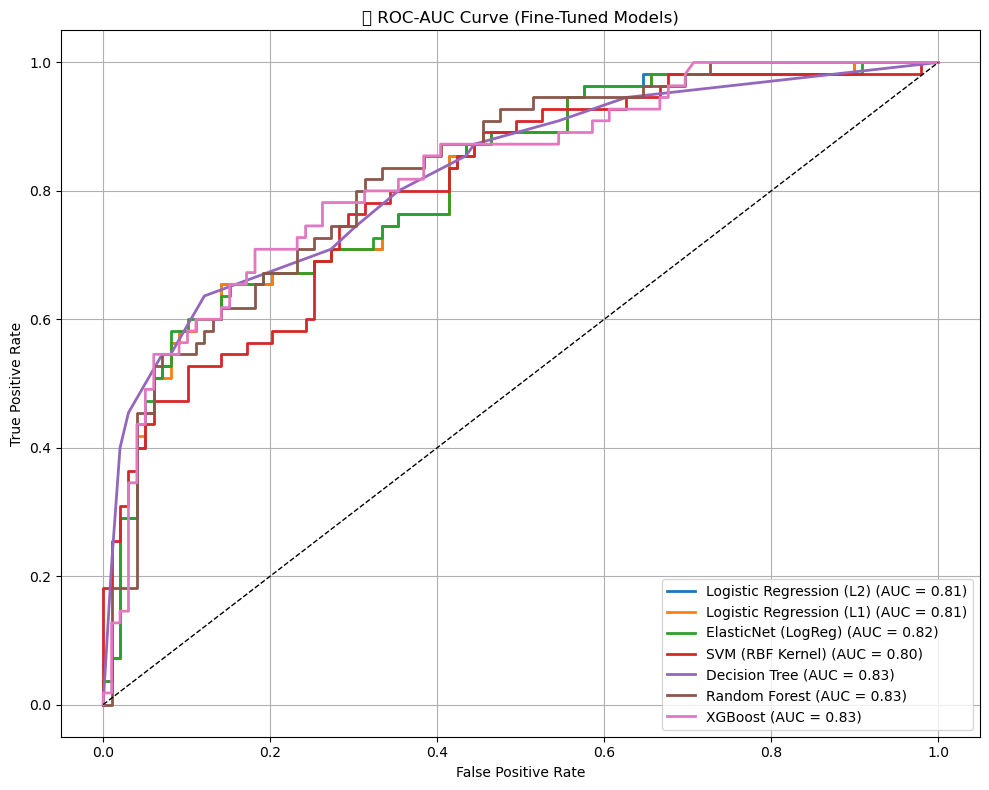

In [16]:
evaluate_tuned_classifiers(model_grid, X_train, X_test, y_train, y_test)

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Metrics
metrics = {
    'Accuracy': 'accuracy',
    'F1-Score': make_scorer(f1_score),
    'ROC-AUC': 'roc_auc'
}

# Results
for name, scorer in metrics.items():
    scores = cross_val_score(rf_model, X, y, cv=skf, scoring=scorer)
    print(f"✅ {name}: {scores.mean():.4f} ± {scores.std():.4f}")

✅ Accuracy: 0.7500 ± 0.0253
✅ F1-Score: 0.6214 ± 0.0223
✅ ROC-AUC: 0.8267 ± 0.0145


## 🧠 2. Model Training & Evaluation
We train multiple classifiers (Logistic Regression, Random Forest, etc.) and compare their performance using:
- Accuracy
- F1-Score
- ROC-AUC
- Cross-Validation

## 📈 3. ROC-AUC Curve Comparison
The ROC-AUC curve shows how well each model distinguishes between the two classes.

## ✅ 4. Conclusion & Takeaways
- Random Forest Classifier showed strong results.
- ROC-AUC indicates good class separation.
- Future improvements could include SMOTE or hyperparameter tuning.